# **IMPORT DATA**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
path = "/content/drive/My Drive/Akeed_Competition/"

In [3]:
import gc
import math
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [4]:
%%time
import pandas as pd
import warnings
warnings.simplefilter('ignore')
test_customers=pd.read_csv(path +'test_customers.csv')
test_locations=pd.read_csv(path +'test_locations.csv')
train_customers=pd.read_csv(path +'train_customers.csv')
train_locations=pd.read_csv(path +'train_locations.csv')
vendors=pd.read_csv(path +'vendors.csv')
vendors = vendors.add_prefix('v_')

orders=pd.read_csv(path +'orders.csv')


#SampleSubmission = pd.read_csv(path + "SampleSubmission (8).csv")

CPU times: user 663 ms, sys: 83 ms, total: 746 ms
Wall time: 4.96 s


# **Create final train & test**

In [5]:
def reduce_mem_usage(df, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)

  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

  return df

In [6]:
def prepare_orders(orders) :
    
    ################################### Vendor Statistics  ###################################################################

    vendor_stats = orders.groupby(by="vendor_id",as_index=False).agg({ 
        'customer_id':['count','nunique'],
        'item_count':['mean','min' ,'std'],
        'grand_total':['mean','min' ,'std'],
        'driver_rating' : ['mean','std'],
        'deliverydistance' : ['std','mean','min'],
        
        })
    vendor_stats.columns = ["_".join(x) for x in vendor_stats.columns.ravel()]
    
    vendor_stats['nb_reordered'] = (vendor_stats['customer_id_count']-vendor_stats['customer_id_nunique'])
    
    
    return vendor_stats

In [7]:
def prepare_vendors(vendors,vendor_stats):

      #merging stats with vendors
      vendors = pd.merge(vendors,vendor_stats,how="left",right_on="vendor_id_",left_on="v_id")
      
      
      
      
      ############################################   FEATURE ENGINEERING  ON VENDORS ###############################################
      
      vendors['length_of_tags'] = vendors['v_vendor_tag_name'].str.split(',').str.len().fillna(0).astype('int')
      vendors['quality'] = vendors['length_of_tags'] * vendors['v_vendor_rating']
      
      
      
      #################################     Here i will calculate Hours of work  & services per week   ###################################
      
      
      
      vendors['v_total_hours_per_week'] = 0
      vendors['v_total_services_per_week'] = 0

      for i , col in enumerate([('v_sunday_from_time2','v_sunday_to_time2'),('v_monday_from_time2','v_monday_to_time2'),('v_tuesday_from_time2','v_tuesday_to_time2'),('v_wednesday_from_time2','v_wednesday_to_time2'),('v_thursday_from_time2','v_thursday_to_time2'),('v_friday_from_time2','v_friday_to_time2'),('v_saturday_from_time2','v_saturday_to_time2')]) :
            vendors[col[0]] = pd.to_datetime(vendors[col[0]], yearfirst=True)
            vendors[col[1]] = pd.to_datetime(vendors[col[1]], yearfirst=True)
            #hours
            vendors[f'time2_diff_of_day_{i}'] = vendors[col[1]] - vendors[col[0]]
            vendors[f'time2_diff_of_day_{i}']  =vendors[f'time2_diff_of_day_{i}'].apply(number_of_hours)
            vendors['v_total_hours_per_week']  = vendors['v_total_hours_per_week'] + vendors[f'time2_diff_of_day_{i}']

            del vendors[f'time2_diff_of_day_{i}']
            #minutes
            vendors[f'time2_diff_minutes_of_day_{i}'] = vendors[col[1]] - vendors[col[0]]
            
            vendors[f'time2_diff_minutes_of_day_{i}']  =vendors[f'time2_diff_minutes_of_day_{i}'].apply(number_of_minutes)
            vendors[f'estimated_number_of_services_on_day_{i}'] = vendors[f'time2_diff_minutes_of_day_{i}'] // vendors['v_prepration_time']
            vendors['v_total_services_per_week'] = vendors['v_total_services_per_week'] + vendors[f'estimated_number_of_services_on_day_{i}']

            del vendors[f'time2_diff_minutes_of_day_{i}']
            del vendors[f'estimated_number_of_services_on_day_{i}']

        

      return vendors

In [8]:
def pre_final_df(train_customers,train_locations,vendors) :
      train_customers = train_customers.drop_duplicates("akeed_customer_id").reset_index()
      train_locations=train_locations.rename(columns = {"customer_id":"akeed_customer_id"})
      First_Train= train_customers.merge(train_locations,on="akeed_customer_id",how="right")
      First_Train = First_Train.add_prefix('cust_')
       
      pre_Final_df = vendors.assign(key=1).merge(First_Train.assign(key=1), on='key').drop('key',axis=1)

      return pre_Final_df

In [9]:
def number_of_hours(duration):
    time_s = duration.total_seconds()
    nb_hours = divmod(time_s, 3600)[0]
    return nb_hours

In [10]:
def number_of_minutes(duration):
    time_s = duration.total_seconds()
    nb_minutes = divmod(time_s, 60)[0]
    return nb_minutes

In [11]:
def days(duration):
    time_s = duration.total_seconds()
    nb_days = divmod(time_s, 86400)[0]
    return nb_days

In [12]:
def haversine(lat1, lon1, lat2, lon2 ):
    
    
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    lat_diff = lat2 - lat1
    long_diff = lon2 - lon1
    distance = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(long_diff * 0.5) ** 2
    haversine_ = 2 * 6371 * np.arcsin(np.sqrt(distance))
    return haversine_

In [13]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [14]:
def manhattan_distance(lat1, lon1, lat2, lon2):
    
    h1 = haversine(lat1, lon1, lat1, lon2)
    h2 = haversine(lat1, lon1, lat2, lon1)
    return h1 + h2

In [15]:
def bearing(lat1, lon1, lat2, lon2):
    lon_rad = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    
    return np.degrees(np.arctan2(np.sin(lon_rad) * np.cos(lat2), np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_rad)))

In [16]:
def sphere_volume(r):
  pi = 3.1415926535897931
  V= 4.0/3.0*pi* r**3
  return V 

In [17]:
def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree) 

In [18]:
def calculateDistance2D(x1,y1,x2,y2):  
  """
  return 2D distance
  """
  dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
  return dist  

In [19]:
def process_df(df):
    
     

    ################################ Distance FEATURE ENGINEERING #########################################################
    
    df['harvesine_dist'] = haversine(df['cust_latitude'], df['cust_longitude'], df['v_latitude'], df['v_longitude']) /1000
    df['manhattan_dist'] = manhattan_distance(df['cust_latitude'], df['cust_longitude'], df['v_latitude'], df['v_longitude']) /1000
    df['other_dist'] = distance(df['cust_latitude'], df['cust_longitude'], df['v_latitude'], df['v_longitude']) /1000
    df['bearing'] = bearing(df['cust_latitude'], df['cust_longitude'], df['v_latitude'], df['v_longitude']) 
    
    #distance ratio
    df['distance_ratio_1'] = df['harvesine_dist'] / df['v_serving_distance']
    df['distance_ratio_2'] = df['manhattan_dist'] / df['v_serving_distance']
    df['distance_ratio_3'] = df['other_dist'] / df['v_serving_distance']

    #distance diffirence
    df['distance_diff_1'] = df['harvesine_dist'] - df['v_serving_distance']
    df['distance_diff_2'] = df['manhattan_dist'] - df['v_serving_distance']
    df['distance_diff_3'] = df['other_dist'] - df['v_serving_distance']

    
    ################################ SIMPLE FEATURE ENGINEERING #########################################################
    df['cust_gender'] = df.cust_gender.str.strip()   # remove spaces
    df.replace({'cust_gender': {'male': 'Male', '?????': 'NaN', '': 'NaN'}}, inplace=True)    
    df.replace({'v_OpeningTime2': {'-': 'NaN'}}, inplace=True)
    
    ################################ LATITUDE & LOGITUDE FEATURE ENGINEERING #########################################################
    # 1-Original Latitude & longitude 
    # Centre 
    df['center_latitude'] = (df['cust_latitude'].values + df['v_latitude'].values) / 2
    df['center_longitude'] = (df['cust_longitude'].values + df['v_longitude'].values) / 2
    # Convulution + ration of diffirence 
    df['conv1'] = df['cust_latitude']*df['v_latitude'] # remove abs
    df['conv2'] = df['cust_longitude']*df['v_longitude'] # remove abs
    
    df['conv3'] = df['conv1'] *df['conv2']

    df['SUM_LAT_LONG'] = df['cust_latitude'] + df['v_latitude'] + df['cust_longitude'] + df['v_longitude'] 

    df['relation1'] = (df['cust_latitude']-df['cust_longitude']) / (df['v_latitude']-df['v_longitude']) # remove abs
    
    df['relation2'] = df['SUM_LAT_LONG'] /   df['conv3'] 
    
    df['relation3'] = (df['cust_latitude']+df['cust_longitude']) / (df['v_latitude']+df['v_longitude']) # new 
    
    # 2- Apply radiant to latitude & longitude 
    df['cust_radiant_latitude'] = radian_conv(df['cust_latitude'])
    df['cust_radiant_longitude'] = radian_conv(df['cust_longitude']) 
    
    df['v_radiant_latitude'] = radian_conv(df['v_latitude']) 
    df['v_radiant_longitude'] = radian_conv(df['v_longitude']) 
    
    df['center_radiant_latitude'] = (df['cust_radiant_latitude'].values + df['v_radiant_latitude'].values) / 2
    df['center_radiant_longitude'] = (df['cust_radiant_longitude'].values + df['v_radiant_longitude'].values) / 2

    df['radiant_conv1'] = abs(df['cust_radiant_latitude']*df['v_radiant_latitude'])
    df['radiant_conv2'] = abs(df['cust_radiant_longitude']*df['v_radiant_longitude'])

    #3-Apply cos and sin : Normalization :) 
      ## customer
    df['cust_latitude_cos'] = np.cos(df['cust_radiant_latitude'])
    df['cust_latitude_sin'] = np.sin(df['cust_radiant_latitude'])
    df['cust_longitude_cos'] = np.cos(df['cust_radiant_longitude'])
    df['cust_longitude_sin'] = np.sin(df['cust_radiant_longitude'])

     ##customer transforming to x y z coordinates 
    df['cust_x_coordinate'] = df['cust_longitude_cos'] * df['cust_latitude_cos']
    df['cust_y_coordinate'] = df['cust_longitude_sin'] * df['cust_latitude_cos']
    df['cust_z_coordinate'] = df['cust_latitude_sin']

     ## VENDOR
    df['v_latitude_cos'] = np.cos(df['v_radiant_latitude'])
    df['v_latitude_sin'] = np.sin(df['v_radiant_latitude'])
    df['v_longitude_cos'] = np.cos(df['v_radiant_longitude'])
    df['v_longitude_sin'] = np.sin(df['v_radiant_longitude'])    

     ## VENDOR transforming to x y z coordinates 
    df['v_x_coordinate'] = df['v_longitude_cos'] * df['v_latitude_cos']
    df['v_y_coordinate'] = df['v_longitude_sin'] * df['v_latitude_cos']
    df['v_z_coordinate'] = df['v_latitude_sin'] 




    # OTHER PROPOSED features 
    df['time_consuming'] = (df['distance_diff_1'] / 30) / (df['v_prepration_time'] * 5 )  

    # distance 2D space between vendor customer 
    df['2D_distance'] = calculateDistance2D(df['cust_x_coordinate'],df['cust_y_coordinate'],df['v_x_coordinate'],df['v_y_coordinate'])

    #sphere volume ########### New 
    df['sphere_cust']= sphere_volume(df['2D_distance'])
    df['sphere_v']= sphere_volume(df['v_serving_distance'])

    

    ################################ TIME FEATURE ENGINEERING #########################################################

    df['cust_created_at'] = pd.to_datetime(df['cust_created_at'], yearfirst=True)
    df['cust_updated_at'] = pd.to_datetime(df['cust_updated_at'], yearfirst=True)
    df['v_created_at'] = pd.to_datetime(df['v_created_at'], yearfirst=True)
    df['v_updated_at'] = pd.to_datetime(df['v_updated_at'], yearfirst=True)

    df['cust_diff_update_create'] = df['cust_updated_at'] - df['cust_created_at']
    df['v_diff_update_create'] = df['v_updated_at'] - df['v_created_at']
    df['cust_v_diff_create'] = df['v_created_at'] - df['cust_created_at']
    df['cust_v_diff_update'] = df['v_updated_at'] - df['cust_updated_at']

    df['cust_diff_update_create'] = df['cust_diff_update_create'].apply(days)
    df['v_diff_update_create'] = df['v_diff_update_create'].apply(days)
    df['cust_v_diff_create'] = df['cust_v_diff_create'].apply(days)
    df['cust_v_diff_update'] = df['cust_v_diff_update'].apply(days)
    
    df['year_cust_created_at'] = df['cust_created_at'].dt.year
    df['month_cust_created_at'] = df['cust_created_at'].dt.month
    df['doy_cust_created_at'] = df['cust_created_at'].dt.dayofyear
    df['woy_cust_created_at'] = df['cust_created_at'].dt.weekofyear
    df['wday_cust_created_at'] = df['cust_created_at'].dt.weekday

    df['year_cust_updated_at'] = df['cust_updated_at'].dt.year
    df['month_cust_updated_at'] = df['cust_updated_at'].dt.month
    df['doy_cust_updated_at'] = df['cust_updated_at'].dt.dayofyear
    df['woy_cust_updated_at'] = df['cust_updated_at'].dt.weekofyear
    df['wday_cust_updated_at'] = df['cust_updated_at'].dt.weekday

    df['year_v_created_at'] = df['v_created_at'].dt.year
    df['month_v_created_at'] = df['v_created_at'].dt.month
    df['doy_v_created_at'] = df['v_created_at'].dt.dayofyear
    df['woy_v_created_at'] = df['v_created_at'].dt.weekofyear
    df['wday_v_created_at'] = df['v_created_at'].dt.weekday

    df['year_v_updated_at'] = df['v_updated_at'].dt.year
    df['month_v_updated_at'] = df['v_updated_at'].dt.month
    df['doy_v_updated_at'] = df['v_updated_at'].dt.dayofyear
    df['woy_v_updated_at'] = df['v_updated_at'].dt.weekofyear
    df['wday_v_updated_at'] = df['v_updated_at'].dt.weekday
    
    del df['cust_created_at']
    del df['cust_updated_at']
    del df['v_created_at']
    del df['v_updated_at']
    gc.collect()
    
    
    #################################   Statistics Based on CUSTOMER ID :D ################################################################
    distance_statique = df.groupby(by="cust_akeed_customer_id",as_index=False).agg({ 
        'distance_diff_2':['mean','min','max'],
        'distance_ratio_2' : ['max','min','mean'],
        'harvesine_dist' : ['std','mean'],
        'bearing' : ['std','median','min','max'], ## add median min max 
        'SUM_LAT_LONG' :['std','mean','min','max'], 
        'relation1' :['std','mean'],
        'relation2' :['std','mean'],
        'relation3' :['std','mean','min'],
        'center_longitude' : ['std','mean'] ,
        'center_latitude' : ['std','mean'] ,
        'cust_diff_update_create' : ['mean','std','max','min'],
        'cust_v_diff_update' : ['mean','max','min'],
        'cust_v_diff_create' : ['mean','min','max'],
        'conv3' : ['std','mean','min','max'], # new mean 
        'radiant_conv1' : ['mean',],
        'radiant_conv2' : ['mean',],
        'v_id':['nunique'],
        'time_consuming' : ['std','mean'],
        '2D_distance' : ['std','mean','max','min','median'],
       })
    distance_statique.columns = ["_".join(x) for x in distance_statique.columns.ravel()]
    
    df = pd.merge(df,distance_statique,how="left",right_on="cust_akeed_customer_id_",left_on="cust_akeed_customer_id")

    df['realtion4'] = df['relation3_mean'] * df['relation1_mean']
    df['relation5'] = 2*df['conv3_mean'] / df['SUM_LAT_LONG_mean']

    df['quality2'] = df['cust_v_diff_update_mean'] - df['cust_v_diff_create_mean'] 
    df['quality3'] = df['time_consuming_mean'] * df['v_vendor_rating']

    df['speed_max'] = df['cust_v_diff_update_max'] -df['cust_v_diff_update_min']
    df['factor_of_speed'] = df['harvesine_dist_mean'] / df['time_consuming_mean']

    df['customer_choice'] = df['v_vendor_rating'] /  df['v_id_nunique']
    df['ratio_distance_2D'] = df['2D_distance_max'] / df['2D_distance_min']

    ##################################### Statistics based on location number #####################################
    create_update_statique = df.groupby(by="cust_location_number",as_index=False).agg({ 
        'cust_akeed_customer_id':['count','nunique'],
        'v_id':['count','nunique'],
        'v_serving_distance' :['mean'],

        'v_vendor_rating':['mean','std'],
        'length_of_tags' :['mean'],
        'cust_dob' : ['mean','std'],
        'harvesine_dist' : ['mean'],


       })
    create_update_statique.columns = ["_perlocation_".join(x) for x in create_update_statique.columns.ravel()]
    #############
    create_update_statique['pure_vendors'] = create_update_statique['v_id_perlocation_count'] - create_update_statique['v_id_perlocation_nunique']
    
    df = pd.merge(df,create_update_statique,how="left",right_on="cust_location_number_perlocation_",left_on="cust_diff_update_create")

    
    return df

# **Apply**

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def Label_enc(df) :
    le_cols =  ['v_sunday_from_time1','v_sunday_to_time1','v_monday_from_time1','v_monday_to_time1','v_tuesday_from_time1',
                'v_tuesday_to_time1','v_tuesday_to_time2',
                 'v_wednesday_from_time1','v_wednesday_to_time1','v_thursday_from_time1','v_thursday_to_time1','v_friday_from_time1',
                 'v_friday_to_time1','v_saturday_from_time1','v_saturday_to_time1',
                 'v_sunday_from_time2','v_sunday_to_time2','v_monday_from_time2','v_monday_to_time2','v_tuesday_from_time2',
                'v_wednesday_from_time2','v_wednesday_to_time2','v_thursday_from_time2','v_thursday_to_time2','v_friday_from_time2',
                 'v_friday_to_time2','v_saturday_from_time2','v_saturday_to_time2',]
    for col in le_cols:
    
      df[col][pd.isnull(df[col])]  = 'nan'
      df[col+'LAB_ENC']= le.fit_transform(df[col])
    return df

In [21]:
%%time
vendors = Label_enc(vendors)

CPU times: user 64.1 ms, sys: 0 ns, total: 64.1 ms
Wall time: 66.4 ms


In [22]:
%%time
vendor_stats = prepare_orders(orders)
vendors = prepare_vendors(vendors,vendor_stats)

CPU times: user 168 ms, sys: 2.68 ms, total: 170 ms
Wall time: 228 ms


In [23]:
vendors.drop(['v_sunday_from_time1','v_sunday_to_time1','v_monday_from_time1','v_monday_to_time1','v_tuesday_from_time1','v_tuesday_to_time1',
            'v_wednesday_from_time1','v_wednesday_to_time1','v_thursday_from_time1','v_thursday_to_time1','v_friday_from_time1',
            'v_friday_to_time1','v_saturday_from_time1','v_saturday_to_time1',
            'v_sunday_from_time2','v_sunday_to_time2','v_monday_from_time2','v_monday_to_time2','v_tuesday_from_time2',

            'v_wednesday_from_time2','v_wednesday_to_time2','v_thursday_from_time2','v_thursday_to_time2','v_friday_from_time2',
            'v_friday_to_time2','v_saturday_from_time2','v_saturday_to_time2',
            'v_monday_from_time1LAB_ENC',	'v_monday_to_time1LAB_ENC'	,'v_tuesday_from_time1LAB_ENC'	,'v_tuesday_to_time1LAB_ENC',	
            'v_thursday_to_time1LAB_ENC',	'v_friday_from_time1LAB_ENC',	'v_friday_to_time1LAB_ENC' ,'v_wednesday_to_time1LAB_ENC',
            'v_friday_from_time2LAB_ENC',	'v_friday_to_time2LAB_ENC', 'vendor_id_','customer_id_count','customer_id_nunique',
            'v_thursday_from_time1LAB_ENC'	,'v_tuesday_to_time2','v_wednesday_from_time1LAB_ENC',
            'v_monday_from_time2LAB_ENC' ,	'v_monday_to_time2LAB_ENC',	'v_tuesday_from_time2LAB_ENC',	'v_tuesday_to_time2LAB_ENC',
            'v_wednesday_from_time2LAB_ENC',	'v_wednesday_to_time2LAB_ENC'	,'v_thursday_from_time2LAB_ENC',	'v_thursday_to_time2LAB_ENC',],
            axis=1,inplace=True)

In [24]:
%%time

pre_Final_train = pre_final_df(train_customers, train_locations, vendors)
pre_Final_test = pre_final_df(test_customers, test_locations, vendors)

CPU times: user 16.6 s, sys: 2.05 s, total: 18.6 s
Wall time: 18.6 s


In [25]:
%%time

pre_Final_train = reduce_mem_usage(pre_Final_train)
pre_Final_test = reduce_mem_usage(pre_Final_test)

Memory usage after optimization is: 1322.19 MB
Decreased by 57.8%
Memory usage after optimization is: 371.53 MB
Decreased by 57.8%
CPU times: user 11.8 s, sys: 56.1 ms, total: 11.8 s
Wall time: 11.8 s


In [26]:
%%time

train = process_df(pre_Final_train)
test = process_df(pre_Final_test)

CPU times: user 6min 17s, sys: 4.52 s, total: 6min 22s
Wall time: 6min 22s


In [27]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

del pre_Final_train , pre_Final_test
gc.collect()

Memory usage after optimization is: 3262.92 MB
Decreased by 28.7%
Memory usage after optimization is: 916.86 MB
Decreased by 28.7%
CPU times: user 28.7 s, sys: 91.8 ms, total: 28.8 s
Wall time: 28.8 s


In [28]:
le = LabelEncoder()
def Label_enc(df) :
    le_cols =  ['cust_location_type','v_OpeningTime','v_OpeningTime2',
                  'v_vendor_category_en',
                  'cust_gender',] 
                 
                
    le_cols = list(set(le_cols))
    for col in le_cols:
      print(30 * '=')
      print('Label_enc TO ---> : ' ,col)
      df[col][pd.isnull(df[col])]  = 'nan'
      df[col]= le.fit_transform(df[col])
    return df

In [29]:
%%time

train = Label_enc(train)
test = Label_enc(test)

Label_enc TO ---> :  v_OpeningTime2
Label_enc TO ---> :  cust_gender
Label_enc TO ---> :  cust_location_type
Label_enc TO ---> :  v_vendor_category_en
Label_enc TO ---> :  v_OpeningTime
Label_enc TO ---> :  v_OpeningTime2
Label_enc TO ---> :  cust_gender
Label_enc TO ---> :  cust_location_type
Label_enc TO ---> :  v_vendor_category_en
Label_enc TO ---> :  v_OpeningTime
CPU times: user 11.7 s, sys: 80.1 ms, total: 11.8 s
Wall time: 11.8 s


In [30]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage after optimization is: 3064.31 MB
Decreased by 6.1%
Memory usage after optimization is: 861.05 MB
Decreased by 6.1%
CPU times: user 25.3 s, sys: 41.9 ms, total: 25.4 s
Wall time: 25.4 s


In [31]:
orders=pd.read_csv(path +'orders.csv')

def final_train(train,orders):
    train["CID X LOC_NUM X VENDOR"] = train["cust_akeed_customer_id"].astype(str)+' X '+ train["cust_location_number"].astype(str)+' X '+ train["v_id"].astype(str)

    all_services = orders['CID X LOC_NUM X VENDOR'].values.tolist()
    train['target']= train['CID X LOC_NUM X VENDOR'].isin(all_services).astype(int).values
    return train

def final_test(test) :
    test["CID X LOC_NUM X VENDOR"] = test["cust_akeed_customer_id"].astype(str)+' X '+ test["cust_location_number"].astype(str)+' X '+ test["v_id"].astype(str)
    return test

In [32]:
%%time
train = final_train(train,orders)
test = final_test(test)

CPU times: user 10.4 s, sys: 1.16 s, total: 11.5 s
Wall time: 11.5 s


In [33]:
train.drop(['cust_index'] ,1,inplace=True)
test.drop(['cust_index'] ,1,inplace=True)

In [34]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage after optimization is: 3104.03 MB
Decreased by 1.3%
Memory usage after optimization is: 870.62 MB
Decreased by 0.0%
CPU times: user 25.1 s, sys: 43.8 ms, total: 25.1 s
Wall time: 25.1 s


In [35]:
train.shape ,test.shape

((5950300, 207), (1672000, 206))

# **XGB-GPU**

In [36]:
!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git
!pip install catboost

!pip install lightgbm
!pip install xgboost

  Cloning https://github.com/stanfordmlgroup/ngboost.git to /tmp/pip-req-build-6xyre9c5
  Running command git clone -q https://github.com/stanfordmlgroup/ngboost.git /tmp/pip-req-build-6xyre9c5
     |████████████████████████████████| 348kB 3.5MB/s 
  Created wheel for ngboost: filename=ngboost-0.2.4.dev0-cp36-none-any.whl size=41253 sha256=7953012d770dc47cdcf8d5f07e3723a10533d55e801d628b5fbc17d27d166875
  Stored in directory: /tmp/pip-ephem-wheel-cache-ew6ljz_n/wheels/6d/38/b0/7dc3b6546bf28b1cc407b44f75cbecf072fc2bae32e8f6a835
Successfully built ngboost
     |████████████████████████████████| 65.9MB 51kB/s 


In [37]:
import pandas as pd 
import numpy as np 
import math
from datetime import datetime
import random
from sklearn import preprocessing  
import sklearn 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import pandas as pd
import numpy as np
import math
from numba import jit
import lightgbm as lgb
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, classification_report
from scipy.misc import derivative

import matplotlib.pyplot as plt
import seaborn as sns

import gc
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

In [38]:
%%time
train = reduce_mem_usage( train.sort_values(by='cust_akeed_customer_id', ascending=False).reset_index(drop=True) )

Memory usage after optimization is: 3058.64 MB
Decreased by 0.0%
CPU times: user 36.2 s, sys: 358 ms, total: 36.6 s
Wall time: 36.6 s


In [39]:
to_drop = [ 'v_vendor_tag','v_primary_tags','woy_v_updated_at',
'v_wednesday_to_time1LAB_ENC','vendor_id_','v_friday_from_time2LAB_ENC','v_monday_to_time2LAB_ENC',
'distance_diff_3','cust_akeed_customer_id','v_monday_from_time1LAB_ENC','v_monday_from_time2LAB_ENC',
'v_is_akeed_delivering','v_tuesday_to_time2LAB_ENC','cust_customer_id', 'month_cust_created_at','v_z_coordinate','cust_latitude_cos',
'v_thursday_from_time2LAB_ENC','CID X LOC_NUM X VENDOR','year_cust_created_at','cust_verified',
'Low_option','v_wednesday_from_time1LAB_ENC','Multi_option','cust_language','v_tuesday_from_time1LAB_ENC',
'v_tuesday_to_time1LAB_ENC','v_thursday_to_time2LAB_ENC','cust_status',
'month_v_created_at','v_thursday_to_time1LAB_ENC','cust_x_coordinate','v_friday_to_time1LAB_ENC',
'sphere_v_std','v_tuesday_from_time2LAB_ENC','v_nb_tags','v_is_open','v_display_orders','v_verified','v_vendor_tag_name',
'v_wednesday_to_time2LAB_ENC','year_cust_updated_at','woy_v_created_at','v_country_id',
'cust_gender','cust_akeed_customer_id_','cust_z_coordinate','v_one_click_vendor',
'v_thursday_from_time1LAB_ENC','v_language','month_cust_updated_at','v_city_id',
'v_friday_to_time2LAB_ENC','v_authentication_id','target','v_friday_from_time1LAB_ENC',
'distance_ratio_3','v_discount_percentage','year_v_updated_at','sphere_v_max',
'cust_longitude_cos','v_open_close_flags','year_v_created_at','item_count_min',
'v_monday_to_time1LAB_ENC','v_longitude_cos','v_longitude_sin','Medium_option','v_wednesday_from_time2LAB_ENC','v_vendor_category_id',]

features = [c for c in train.columns if c not in to_drop]
len(features)

165

In [40]:
target = train['target']
X_test = train[features][:892500].values
y_test = target[:892500].values

X_train = train[features][892500:].values
y_train = target[892500:].values

In [41]:
%%time



xgb_model  = XGBClassifier(
                       n_estimators = 900 ,
                       learning_rate=0.1,
                       max_depth=8,
                       min_child_weight=12,
                       scale_pos_weight=7.3,
                       seed=1000,
                       subsample=1,
                       verbosity=1,
                       tree_method='gpu_hist',
                       gpu_id = 0,
)

CPU times: user 34 µs, sys: 1e+03 ns, total: 35 µs
Wall time: 37.9 µs


In [42]:
%%time

xgb_model.fit(X_train, y_train, eval_metric='auc')

CPU times: user 1min 59s, sys: 1min 10s, total: 3min 10s
Wall time: 3min 10s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=12, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.3, seed=1000,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [43]:
pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [44]:
from sklearn.metrics import f1_score
best_score = -1
best_threshold = 0
score= 0 
for i in np.arange(0.45, 0.55, 0.0005):

  pred_xgb = (pred_proba_xgb >= i)*1
  
  score = f1_score(y_test, pred_xgb) 
  if score > best_score:
    best_score= score
    best_threshold = i
    print("Current Best threshold : ",best_threshold )
    print("Current Best Score : ",best_score )
    print("********************")

Current Best threshold :  0.45
Current Best Score :  0.25097915350600125
********************
Current Best threshold :  0.4505
Current Best Score :  0.2511154004366674
********************
Current Best threshold :  0.4515
Current Best Score :  0.25114271203656674
********************
Current Best threshold :  0.452
Current Best Score :  0.2512639511590194
********************
Current Best threshold :  0.4525
Current Best Score :  0.2513852620852175
********************
Current Best threshold :  0.453
Current Best Score :  0.25152298025707265
********************
Current Best threshold :  0.4535
Current Best Score :  0.2516458932566315
********************
Current Best threshold :  0.454
Current Best Score :  0.2517285531370039
********************
Current Best threshold :  0.4545
Current Best Score :  0.251891753238425
********************
Current Best threshold :  0.455
Current Best Score :  0.2520787184179268
********************
Current Best threshold :  0.4555
Current Best Score : 

In [45]:
pred = (pred_proba_xgb >= best_threshold)*1
print('F1 Score : {} , mean_preds : {} '.format(f1_score(y_test, pred),np.mean(pred)) )

F1 Score : 0.25463319113224697 , mean_preds : 0.018568067226890757 


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    880474
           1       0.22      0.30      0.25     12026

    accuracy                           0.98    892500
   macro avg       0.61      0.64      0.62    892500
weighted avg       0.98      0.98      0.98    892500



In [47]:
test_id = test['CID X LOC_NUM X VENDOR']
full_pred = xgb_model.predict_proba(test[features].values)[:,1]

# **SAVE - BINARY**

In [48]:
submission = pd.DataFrame()
submission['CID X LOC_NUM X VENDOR'] = test_id
submission['target'] = (full_pred >= best_threshold)*1
submission.target.value_counts()

0    1640069
1      31931
Name: target, dtype: int64

In [54]:
submission.to_csv('XGBOOST_Binary.csv',index=False)

In [55]:
!cp XGBOOST_Binary.csv '/content/drive/My Drive/BEST_blends_akeed'

# **SAVE - FLOATS**

In [56]:
submission = pd.DataFrame()
submission['CID X LOC_NUM X VENDOR'] = test_id
submission['target'] = full_pred

In [57]:
submission.to_csv('XGBOOST_FLOATS.csv',index=False)
!cp XGBOOST_FLOATS.csv '/content/drive/My Drive/BEST_blends_akeed'

# **Feature Importance**

In [50]:
importance_df = pd.DataFrame()
importance_df["feature"] = features
importance_df["importance"] = xgb_model.feature_importances_*1000

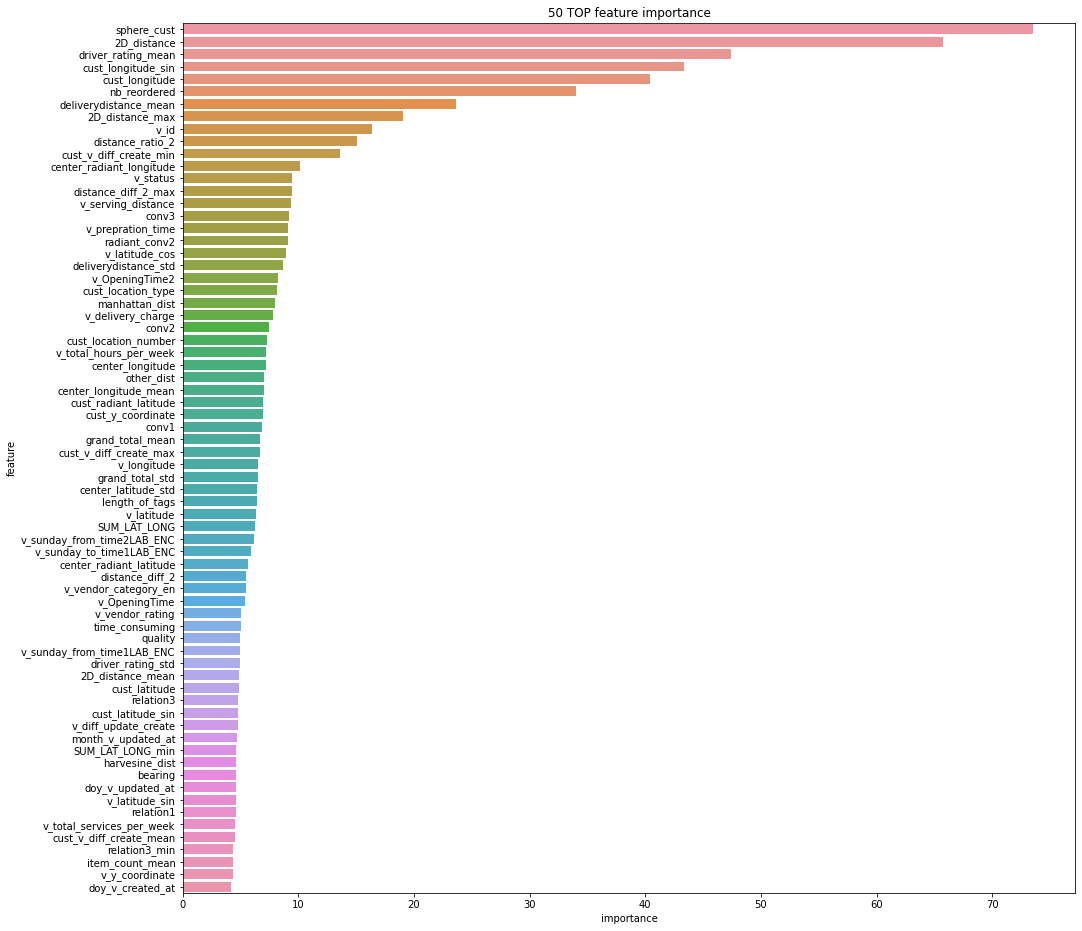

In [51]:
plt.figure(figsize=(16, 16))
sns.barplot(data=importance_df.sort_values(by='importance', ascending=False).head(70), x='importance', y='feature');
plt.title('50 TOP feature importance');